In [13]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; }
.container {width:95% !important;}
</style>

In [14]:
import numpy as np
%matplotlib notebook
from scipy import fftpack
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import SVG
from style import *

def color2bw(img):
    return np.dot(img, [0.299, 0.587, 0.114]) 

## Ancho de banda de un video

- ¿Cúanto pesa una imagen RGB de 1920x1080?

<center>1920 1080 3 size(uint8) = 49.766.400 b ~ 50 Mb</center>

- Tradicionalmente un video es una secuencia de imágenes a 24 cuadros por segundo (fps)
- ¿Cuánto ancho de banda se necesita para ver una película en tiempo real?

<center>50Mb  24 fps = 1200 Mb/s = 1.2 Gb/s</center>

- Este ancho de banda es infactible ¿Qué necesitamos para que un servicio de streaming pueda funcionar?

https://toolstud.io/video/filesize.php

# Compresión de datos

- Codificar la información usando "menos bits" que la representación original
- La compresión puede ser de tipo
    - *Lossless* (sin pérdidas): Los datos originales pueden reconstruirse perfectamente
    - *Lossy* (con pérdidas): Se reconstruye una versión aproximada de los datos originales


Recordemos el modelo de Shannon

<img src="images/shannon-diagram.svg" width="500">


Podemos hacer un modelo más detallado para el **transmisor** como

<img src="images/transmitter.svg" width="600">

donde


- **Transformación:** Cambia la representación de los datos para eliminar redundancia/correlaciones 
- **Cuantización:** Escoge un número fijo de valores representativos (diccionario), es decir acorta el "largo de palabra" de los datos
    - Largo de palabra: Cantidad de bits necesaria para representar un símbolo de código
    - Diccionario o alfabeto: Conjunto de símbolos o palabras
- **Codificación de fuente:** Convierte el diccionario fijo del cuantizador en un código de largo variable, que es más eficiente de transmitir
- **Codificación de canal:** Se encarga de "robustecer" el resultado anterior para que sobreviva la transmisión digital (parity, checksum)

## Compresión de imágenes

- Una imagen se puede proyectar al espacio de frecuencias sin pérdida de información
- En general vimos que la información se concentra en el centro del espectro
- Las tres redundancias:
    -  **Redundancia interpixel (transformación)** Alta correlación entre píxeles vecinos 
    - **Redundancia psicovisual (cuantización):** El ojo humano no puede resolver más de 32 niveles de grises:
    - **Redundancia de codificación:** Algunos tonos son más comunes que otros 
 

¿Cómo explotamos esto para reducir el tamaño de una imagen?

##  Ejemplo: Joint Photographic Experts Group (JPEG)

- Formato ampliamente usado para distribuir imágenes digitales
- Es un algoritmo de compresión con pérdidas para imágenes (lossy)
- Explota las siguientes características del sistema visual humano
    - Somos más sensibles a la iluminación que al color
    - Somos menos sensibles a los componentes de alta frecuencia
- Más componentes descartados: mayor compresión, y peor la calidad


Algoritmo:
1. Paso preliminar: RGB a YCbCr (y downsampling 4:2:2)
1. Transformación con **Discrete Cosine Transform** (DCT) en bloques de 8x8 sin traslape
1. Cuantización escalar
1. Codificación de Huffman


### Espacio YCbCr
- Y es la luminancia
- Cb y Cr son los componentes cromáticos azul y rojo, respectivamente

$$
Y = K_R R + K_G G + K_B B \\
C_b = 0.5 \frac{B - Y}{1 - K_B} \\
C_R = 0.5 \frac{R - Y}{1 - K_R}
$$
donde $K_R + K_G + K_B = 1$.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


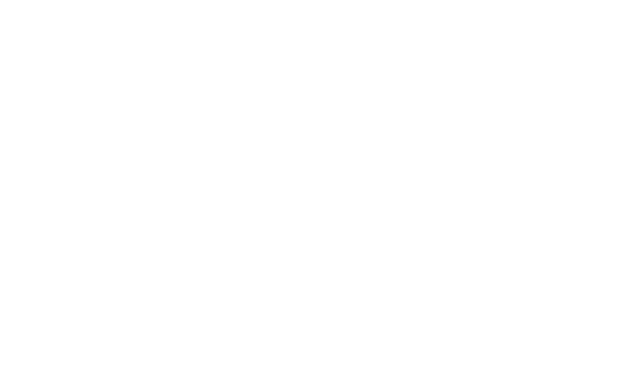

In [15]:
# ITU-R BT.601 
dogo_color = plt.imread('images/lobo.jpg')
Y = color2bw(dogo_color)

plt.matshow(Y, cmap=plt.cm.Greys_r); plt.axis('off'); plt.title('Y')
C_b = np.dot(dogo_color, [-0.168736, -0.3312, 0.5])
plt.matshow(C_b, cmap=plt.cm.Greys_r); plt.axis('off'); plt.title('Cb')
C_r = np.dot(dogo_color, [0.5, -0.4186, -0.0813])
plt.matshow(C_r, cmap=plt.cm.Greys_r); plt.axis('off'); plt.title('Cr');

In [16]:
plt.close(); fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)

def update(q_Y, q_C):
    ax.cla(); ax.axis('off')
    Y = np.round(np.dot(dogo_color, [0.299, 0.587, 0.114])*q_Y/255.0)*255.0/q_Y
    C_b = 128+np.round(np.dot(dogo_color, [-0.168736, -0.3312, 0.5])*q_C/255.0)*255.0/q_C
    C_r = 128+np.round(np.dot(dogo_color, [0.5, -0.4186, -0.0813])*q_C/255.0)*255.0/q_C
    rgb = np.zeros(shape=(Y.shape[0], Y.shape[1], 3))
    rgb[:,:,0] = Y + 1.402 * (C_r-128)
    rgb[:,:,1] = Y - .34414 * (C_b-128) - .71414 * (C_r-128)
    rgb[:,:,2] = Y + 1.772 * (C_b-128)
    np.putmask(rgb, rgb > 255, 255);
    np.putmask(rgb, rgb < 0, 0);    
    ax.imshow(np.uint8(rgb));
   
interact(update, q_Y=SelectionSlider_nice(options=[1, 2, 4, 8, 16, 32, 64, 128], value=128, description="Niveles de Y"),
         q_C=SelectionSlider_nice(options=[1, 2, 4, 8, 16, 32, 64, 128], value=128, description="Niveles de C"));

<IPython.core.display.Javascript object>

interactive(children=(SelectionSlider(continuous_update=False, description='Niveles de Y', index=7, layout=Lay…

## Discrete Cosine Transform (DCT)

Sea una señal discreta y bidimensional $g[n_1, n_2]$ con índices $n_1 \in [0, N_1-1]$ y $n_2 \in [0, N_2-1]$ su DCT es 

$$
G_C[k_1, k_2] = \sum_{n_1=0}^{N_1-1} \sum_{n_2=0}^{N_2-1} 4 g[n_1, n_2] \cos \left ( \frac{\pi k_1}{2N_1}(2n_1+1)  \right) \cos \left ( \frac{\pi k_2}{2N_2}(2n_2+1)  \right) 
$$
y su inversa

$$
g[n_1, n_2] = \frac{1}{N_1 N_2}\sum_{k_1=0}^{N_1-1} \sum_{k_2=0}^{N_2-1} w[k_1]w[k_2]G[k_1, k_2] \cos \left ( \frac{\pi k_1}{2N_1}(2n_1+1)  \right) \cos \left ( \frac{\pi k_2}{2N_2}(2n_2+1)  \right), 
$$

donde 
$$
w[k] =\begin{cases}
1/2 & \text{ssi} ~~ k=0\\
1 & \text{ssi} ~~ k \neq 0
\end{cases} 
$$

La DCT bidimensional:
- es lineal, y cumple el principio de conservación de energía
- se puede descomponer en 2 aplicaciones de la DCT 1D
- es equivalente a la DFT de una señal "simetricamente extendida":

$$
y[k] =\begin{cases}
x[k] & \text{ssi} ~~ k<N\\
x[2N-1-k] & \text{ssi} ~~ N \leq k < 2N - 1 
\end{cases} 
$$
- Es decir que podemos usar el algoritmo FFT para calcular eficientemente la DCT

**Ojo:** La convolución en espacio original no es multiplicación en el espacio DCT


La base de la DCT:

In [17]:
x = np.arange(0, 32, step=1)
X, Y = np.meshgrid(x, x)
fig, ax = plt.subplots(8, 8, figsize=(9, 8), tight_layout=False)
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
for n in range(ax.shape[0]):
    for m in range(ax.shape[1]):
        cos_x = np.cos(np.pi*(2*X+1)*m/(2*len(x)))
        cos_y = np.cos(np.pi*(2*Y+1)*n/(2*len(x)))
        ax[n, m].matshow(cos_x*cos_y, cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
        ax[n, m].axis('off')


<IPython.core.display.Javascript object>

### Ejemplo: Transformación de una imagen usando DCT en bloques de 8x8

In [18]:
img_seadoge = color2bw(plt.imread('images/lobo.jpg'))  
fig, ax = plt.subplots(figsize=(9, 6)); ax.axis('off')
ax.imshow(img_seadoge, cmap=plt.cm.Greys_r);

<IPython.core.display.Javascript object>

In [19]:
DCT2 = lambda g, norm='ortho': fftpack.dct( fftpack.dct(g, axis=0, norm=norm), axis=1, norm=norm)
IDCT2 = lambda G, norm='ortho': fftpack.idct( fftpack.idct(G, axis=0, norm=norm), axis=1, norm=norm)

imsize = img_seadoge.shape
dct_matrix = np.zeros(shape=imsize)
dft_matrix = np.zeros(shape=imsize, dtype=np.complex128)

for i in range(0, imsize[0], 8):
    for j in range(0, imsize[1], 8):
        dct_matrix[i:(i+8),j:(j+8)] = DCT2( img_seadoge[i:(i+8),j:(j+8)] )
        dft_matrix[i:(i+8),j:(j+8)] = fftpack.fft2( img_seadoge[i:(i+8),j:(j+8)] )  


¿Cómo se ven uno a uno la DCT de los bloques?

<IPython.core.display.Javascript object>


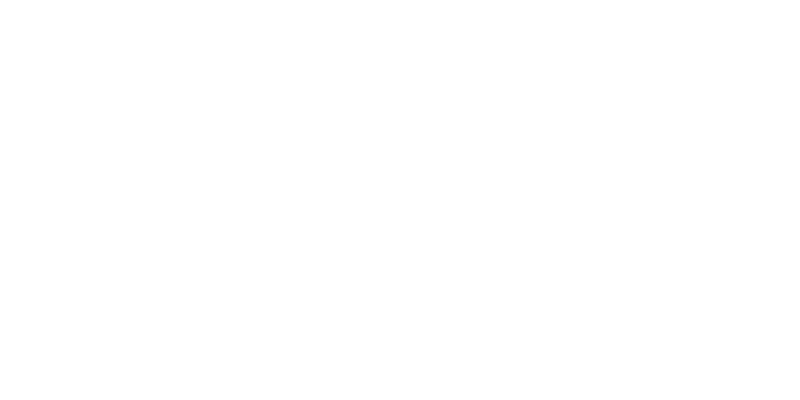

interactive(children=(IntSlider(value=0, continuous_update=False, description='Bloque', layout=Layout(height='…

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

def plot_values(ax, tile, fontsize=16):
    for i in range(8):
        for j in range(8):
            label = tile[i, j]
            ax.text(i, j, int(label), fontsize=fontsize, 
                    color='black', ha='center', va='center')
            
def update(block_idx=1):
    for ax_ in ax:
        ax_.cla(); ax_.axis('off')
    tile = img_seadoge[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
    ax[0].imshow(tile, cmap=plt.cm.Greys_r, 
                 vmin=img_seadoge.min(), vmax=img_seadoge.max())
    ax[0].set_title("%d 8x8 image block" %(block_idx)); 
    plot_values(ax[0], tile)
    tile = dct_matrix[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
    ax[1].imshow(tile, cmap=plt.cm.Greys_r, 
                 vmin=dct_matrix.min(), vmax=dct_matrix.max())
    ax[1].set_title("8x8 DCT")
    plot_values(ax[1], tile)

interact(update, block_idx=IntSlider_nice(min=0, max=100, value=0, 
                                          description="Bloque"));

¿Cómo se ven los bloques de la DCT si los concatenamos?

In [21]:
plt.close(); 
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
ax.axis('off')
ax.matshow(dct_matrix, cmap=plt.cm.Greys_r, vmin=0, vmax=50);

<IPython.core.display.Javascript object>

Comparemos ahora la DFT y DCT en términos de reconstrucción con pérdidas

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), tight_layout=False)
fig.subplots_adjust(left=0.01, right=0.99, top=0.94, bottom=0.01)
def update(percent):
    for ax_ in ax.ravel():
        ax_.cla(); ax_.axis('off')
    imsize = img_seadoge.shape
    Npixels = imsize[0]*imsize[1]
    im_dct, im_dft = np.zeros(imsize), np.zeros(imsize)
    I = np.unravel_index(np.argsort(np.absolute(dct_matrix), axis=None)[::-1], 
                         dct_matrix.shape)
    dct_thresh = dct_matrix.copy()
    dct_thresh[I[0][int(Npixels*percent/100):], 
               I[1][int(Npixels*percent/100):]] = 0
    I = np.unravel_index(np.argsort(np.absolute(dft_matrix), axis=None)[::-1], 
                         dft_matrix.shape)
    dft_thresh = dft_matrix.copy()
    dft_thresh[I[0][int(Npixels*percent/100):], 
               I[1][int(Npixels*percent/100):]] = 0
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            im_dct[i:(i+8),j:(j+8)] = IDCT2( dct_thresh[i:(i+8),j:(j+8)] )
            im_dft[i:(i+8),j:(j+8)] = np.real(fftpack.ifft2( dft_thresh[i:(i+8),j:(j+8)] ))
    
    ax[0, 0].imshow(im_dft, cmap=plt.cm.Greys_r); 
    ax[0, 0].set_title("DFT")
    ax[1, 0].imshow(im_dft[200:400, 250:600], cmap=plt.cm.Greys_r); 
    ax[0, 1].imshow(im_dct, cmap=plt.cm.Greys_r); 
    ax[0, 1].set_title("DCT")
    ax[1, 1].imshow(im_dct[200:400, 250:600], cmap=plt.cm.Greys_r); 
    
interact(update, percent=SelectionSlider_nice(options=[1., 2.5, 5., 7.5, 10., 20], value=20,
                                          description="Porcentaje de componentes retenidos"));

<IPython.core.display.Javascript object>

interactive(children=(SelectionSlider(continuous_update=False, description='Porcentaje de componentes retenido…

La DCT es equivalente a la DFT de la imagen simetricamente extendida:

<IPython.core.display.Javascript object>


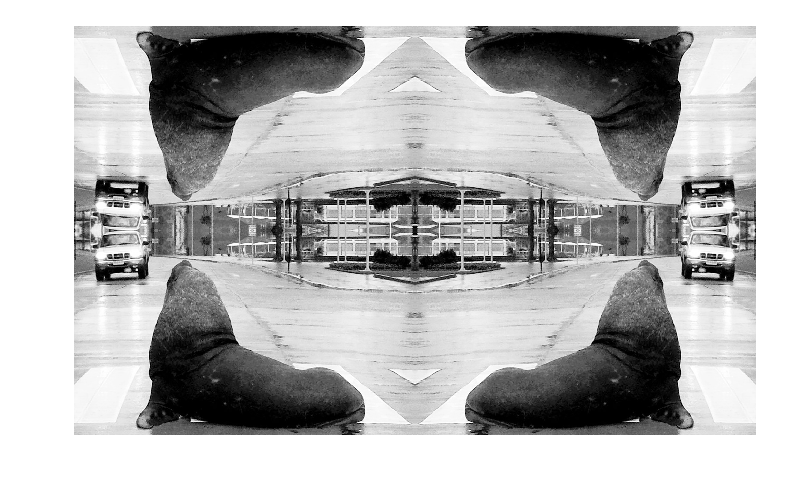

In [23]:
img_seadogo_sym = np.hstack((img_seadoge, np.fliplr(img_seadoge)))
img_seadogo_sym = np.vstack((np.flipud(img_seadogo_sym), img_seadogo_sym))
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
ax.imshow(img_seadogo_sym, cmap=plt.cm.Greys_r);

- DCT y efectos de borde
- optimalidad en termines de aproximacion a transformacion KL
- optimalidad en terminos de señal markoviana con correlacion positiva

## Cuantización escalar

- Objetivo: Atacar la redundancia psicovisual
- Es una operación de redondeo/truncamiento
- Se define por: 
    - número de niveles $L$, 
    - fronteras de decisión $d_i$ 
    - valor de las representaciones $r_i$
$$
\begin{equation}
    Q(x)=
    \begin{cases}
      r_1, & d_0 < x \leq d_1 \\
      \vdots & \vdots \\
      r_i, & d_{i-1} < x \leq d_i \\
      \vdots & \vdots \\
      r_L, & d_{L-1} < x \leq d_L
    \end{cases}
\end{equation}
$$

#### Ejemplo: Cuantización uniforme

Sea un rango de valores en $[-V, V]$, una cuantización uniforme de $L$ niveles sería

$$
d_0 = -V, d_{L} = V
$$
La separación entre niveles es fija
$$
d_{i} = d_{i-1} + \Delta  = d_0 + i \Delta = - V + i \frac{2V}{L}
$$
y el valor de representación es el punto medio de cada nivel
$$
r_i = \frac{1}{2} (d_i + d_{i-1}) = -V + (2i-1) \frac{2V}{L}
$$ 
 


### Error de cuantización

Es la distancia entre el valor real y su versión cuantizada
$$
d_c = \|Q(x) -x\| 
$$

## Cuantización vectorial

Es la extensión del caso anterior a datos multidimensionales, por ejemplo píxeles en formato RGB

- Sea un conjunto de datos N-dimensionales $\{x_1, x_2, \ldots, x_N\}$ con $x_i \in \mathbb{R}^D$
- Se busca un conjunto reducido de prototipos $\{r_1, r_2, \ldots, r_L\}$ donde $L < N$
- La función de cuantización es $Q(x) = r_k$ donde $k = \text{arg}\min_i \|x - r_i\|$
- Hay que definir una métrica de distancia (*e.g* norma L2)

Los prototipos pueden
- ser fijos y estar guardados (look-up table)
- construirse en base a una regla simple (cubos uniformes)
- seleccionar adaptivamente usando el

### Algoritmo *Learning Vector Quantization* (LVQ)
1. Definir una función de distancia
1. Inicializar con prototipos aleatorios
1. Asignar los datos a su prototipo más cercano 
1. Actualizar los prototipos como el valor medio de sus datos asignados
1. Volver al paso 3 hasta converger

Si se usa norma euclidiana (L2) 
$$
\|x - r_i \|_2 = \sqrt{ \sum_{d=1}^D (x[d] - r_i[d])^2 }
$$
se obtiene el famoso algoritmo *K-means*

<center><img src="images/kmeans.gif" width="600"></center>


<IPython.core.display.Javascript object>


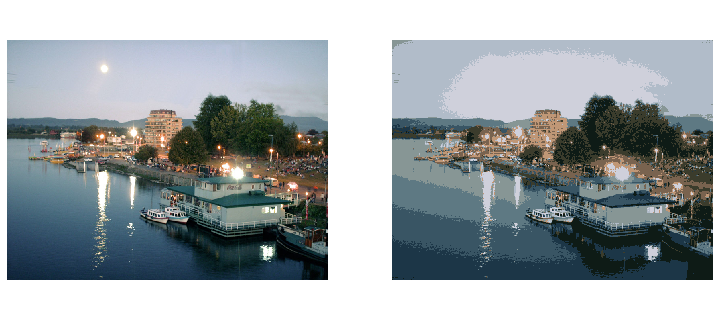

In [25]:
from scipy.cluster.vq import vq
from sklearn.cluster import KMeans
img_color = plt.imread("images/atardecer.jpg")
img_pixels = np.reshape(img_color, (-1, 3))
kmeans = KMeans(n_clusters=10).fit(np.float32(img_pixels)) 
centroids = kmeans.cluster_centers_
qnt,_ = vq(np.float32(img_pixels), centroids)
centers_idx = np.reshape(qnt, (img_color.shape[0], img_color.shape[1]))
clustered = np.uint8(centroids[centers_idx])

fig, ax = plt.subplots(1, 2, figsize=(9, 4), tight_layout=False)
fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
ax[0].imshow(img_color); ax[0].axis('off');
ax[1].imshow(clustered); ax[1].axis('off');

<IPython.core.display.Javascript object>


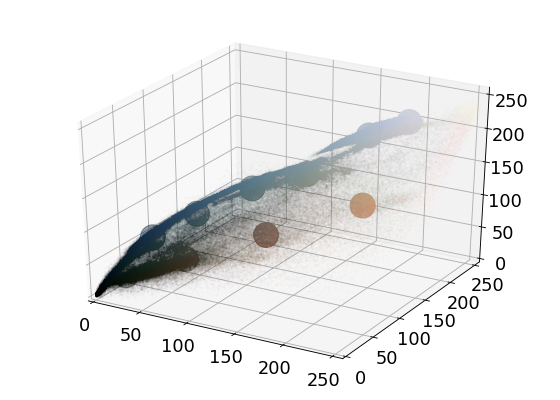

In [27]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=((7, 5)))
ax = fig.gca(projection='3d')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
           c=centroids/255., s=500);
ax.scatter(img_pixels[:, 0], img_pixels[:, 1], img_pixels[:, 2], 
           c=img_pixels/255., s=1, alpha=0.01);
ax.set_xlim([0, 255]); ax.set_ylim([0, 255]); ax.set_zlim([0, 255]);

## Cuantización en JPEG

- JPEG cuantiza en el espacio de frecuencia
- Se cuantizan los bloques de 8x8 componentes DCT 
- El nivel de los componentes se redondea según una matriz de cuantización Q
- Q fue diseñada tal que componentes de alta frecuencia se cuantizan en menos niveles
- El bloque cuantizado se obtiene como $\text{ROUND}\left(\frac{G_C}{Q}\right)$

<IPython.core.display.Javascript object>


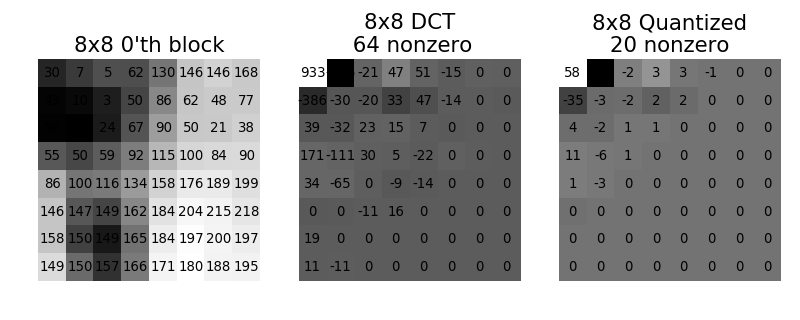

interactive(children=(IntSlider(value=0, continuous_update=False, description='Block tile', layout=Layout(heig…

In [28]:
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],[12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],[14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],[24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],[72, 92, 95, 98, 112, 100, 103, 99]])


fig, ax = plt.subplots(1, 3, figsize=(10, 4), tight_layout=True)
def update(block_idx=1):
    for ax_ in ax:
        ax_.cla(); ax_.axis('off')
    tile = img_seadoge[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
    ax[0].imshow(tile, cmap=plt.cm.Greys_r)
    ax[0].set_title("8x8 %d'th block" %(block_idx)); 
    plot_values(ax[0], tile, fontsize=12)
    tile = dct_matrix[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
    ax[1].imshow(tile, cmap=plt.cm.Greys_r)
    ax[1].set_title("8x8 DCT\n %d nonzero" %(np.count_nonzero(tile))); 
    plot_values(ax[1], tile, fontsize=12)
    quant = np.round(tile/Q)
    ax[2].imshow(quant, cmap=plt.cm.Greys_r)
    ax[2].set_title("8x8 Quantized\n%d nonzero" %(np.count_nonzero(quant))); 
    plot_values(ax[2], quant, fontsize=12)

interact(update, block_idx=IntSlider_nice(min=0, max=100, value=0, description="Block tile"));

<IPython.core.display.Javascript object>


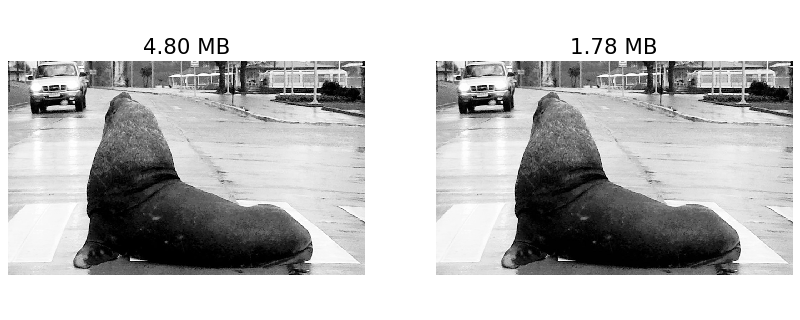

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='Nivel de compresión', lay…

In [29]:
area = img_seadoge.shape[0]*img_seadoge.shape[1]
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=False)
fig.subplots_adjust(left=0.01, right=0.99, top=0.94, bottom=0.01)

def update(percent):
    for ax_ in ax.ravel():
        ax_.cla(); ax_.axis('off')
    im_dct = np.zeros(imsize)
    nnz = np.zeros(dct_matrix.shape)
    if (percent < 50):
        S = 5000/percent
    else:
        S = 200 - 2*percent 
    Q_dyn = np.floor((S*Q + 50) / 100);
    Q_dyn[Q_dyn == 0] = 1
    for i in range(0, imsize[0], 8):
        for j in range(0, imsize[1], 8):
            quant = np.round(dct_matrix[i:(i+8),j:(j+8)]/Q_dyn) 
            im_dct[i:(i+8),j:(j+8)] = IDCT2(quant)
            nnz[i, j] = np.count_nonzero(quant)
    
    ax[0].imshow(img_seadoge, cmap=plt.cm.Greys_r); 
    ax[0].set_title("%0.2f MB" %(area*8/1e+6))
    ax[1].imshow(im_dct, cmap=plt.cm.Greys_r); 
    ax[1].set_title("%0.2f MB" %(np.sum(nnz)*8/1e+6))
interact(update, percent=FloatSlider_nice(min=0, max=100, step=0.01, value=100, 
                                     description="Nivel de compresión"));

# Codificación de fuente

- Es el proceso que asigna un código a cada mensaje
- El largo de las "palabras de código" puede ser **fijo** o **variable**
- **Ejemplo:** Queremos codificar las letras del alfabeto (27) usando dos símbolos (código binario)
    - Para largo fijo necesitamos al menos 5 bits ($2^5 = 32$)
- Pero algunas letras se ocupan más que otras (*e.g.* vocales) 
- ¿Podemos aprovechar esto para comprimir un mensaje?

In [30]:
import string
from collections import Counter

with open('quijote.txt', 'r') as file:
    texto = file.read()
print(texto)
texto = texto.translate({ord(k): None for k in string.digits})
for symbol in string.punctuation:
    texto = texto.replace(symbol, "")
texto = texto.replace(" ", "").replace("\n", "")
texto = texto.lower().encode('ascii', 'ignore').decode("utf-8")
print("\nLargo del texto: {0}, Cantidad de bits: {1}".format(len(texto), len(texto)*5))
Counter(texto).most_common()

En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivÃ­a un hidalgo de los de lanza en astillero, adarga antigua, rocÃ­n flaco y galgo corredor. Una olla de algo mÃ¡s vaca que carnero, salpicÃ³n las mÃ¡s noches, duelos y quebrantos los sÃ¡bados, lentejas los viernes, algÃºn palomino de aÃ±adidura los domingos, consumÃ­an las tres partes de su hacienda. El resto della concluÃ­an sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los dÃ­as de entre semana se honraba con su vellori de lo mÃ¡s fino. TenÃ­a en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que asÃ­ ensillaba el rocÃ­n como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta aÃ±os, era de complexiÃ³n recia, seco de carnes, enjuto de rostro; gran madrugador y amigo de la caza. Quieren decir que tenÃ­a el sobrenombre de Quijada o Quesada (que en esto hay alguna diferencia e

[('a', 317),
 ('e', 315),
 ('o', 201),
 ('s', 190),
 ('n', 161),
 ('l', 160),
 ('r', 151),
 ('d', 123),
 ('u', 113),
 ('i', 110),
 ('c', 100),
 ('t', 89),
 ('m', 61),
 ('b', 46),
 ('q', 41),
 ('p', 41),
 ('y', 34),
 ('g', 26),
 ('h', 23),
 ('v', 23),
 ('f', 15),
 ('z', 14),
 ('j', 11),
 ('x', 1)]

**Intuición:** Podríamos reducir la cantidad de bits si usamos códigos más cortos para las letras más frecuentes

***

# Teoría de la información

- Estudio matemático sobre la cuantificación y transmisión de la información 
- Propuesto por **Claude Shannon** en 1948: *A Mathematical Theory of Communication*
- Proporciona medidas para describir la información de un proceso: **Entropía** e **Información Mutua**
- Aplicaciones en telecomunicaciones, computación y biología (genética)
- Fuerte influencia en la teoría de codificación y compresión

### Las dos fuentes

Sean dos fuentes **F1** y **F2** que pueden emitir uno entre cuatro símbolos: $A$, $B$, $C$ o $D$

**F1** es completamente aleatoria, es decir: $P(A) = P(B) = P(C) = P(D) = \frac{1}{4}$

Si queremos predecir el próximo valor emitido por **F1** ¿Cúal es el número mínimo de preguntas con respuesta si/no que debemos hacer?


<img src="images/information1.svg" width="600">

> La respuesta es 2 para cualquiera de los símbolos

**F2** en cambio emite $A$, $B$, $C$ y $D$ con probabilidades $P(A) =\frac{1}{2}$, $P(B) =\frac{1}{4}$, $P(C) = \frac{1}{8}$ y $P(D) =\frac{1}{8}$, respectivamente

Si queremos predecir el próximo valor retornado por **F2** ¿Cúal es el número mínimo de preguntas con respuesta si/no que debemos hacer? 

<img src="images/information2.svg" width="800">

> La respuesta es 1 para $A$, 2 para $B$ y 3 para $C$ y $D$



# Cantidad de información (según Shannon)

La cantidad de información de un símbolo $x$ es el logaritmo en base dos del recíproco de su probabilidad de aparición

$$
I(x) = \log_2 \left(\frac{1}{P(x)} \right) = \log_2 P(x)^{-1} = - \log_2 P(x),
$$

que es equivalente a la mínima cantidad de preguntas si/no que debemos hacer para adivinar su valor

La cantidad de información se mide en **bits**

>Un **bit** es la cantidad de información que se requiere para escoger entre **dos** alternativas equiprobables

La cantidad de información es también llamada **sorpresa**

> Mientras más improbable es un símbolo, más nos sorprendemos cuando observamos que ocurre

# Entropía

Sea una variable aleatoria $X$ (fuente) con $N$ resultados posibles (símbolos) $\{x_1, x_2, \ldots, x_N\}$

Cada símbolo $x_i$ tiene una probabilidad $p_i \in [0, 1]$ y $\sum_{i=1}^N p_i = 1$ 

Cada símbolo tiene una cantidad de información  $I(x_i) = -\log_2 \left( p_i \right)$ 

Definimos la **cantidad de información promedio** de $X$ como
$$
\begin{align}
H (X) &= \mathbb{E}_{x\sim X} \left [ - \log P(X=x) \right ]  \nonumber \\
&= - \sum_{i=1}^N P(X=x_i) \log_2 P(X=x_i)  \nonumber \\
&= - \sum_{i=1}^N p_i \log_2 p_i  \quad \text{[bits/símbolo]} \nonumber
\end{align}
$$
que se conoce como **Entropía de Shannon** 

### Propiedades
- La entropía es siempre positiva $H(X) \geq 0$. La igualdad se cumple si un $x_i$ tiene $p_i=1$ (caso más predecible)
- La entropia está acotada $H(X) \leq H_0$, donde $H_0= \log_2(N)$ es la entropia si $p_i = \frac{1}{N}~ \forall i$ (caso menos predecible)
- La redundancia de $X$ es $1 - H(X)/H_0$

> Mientras más predecible es $X$ menor es su entropía y mayor es su redundancia




### El retorno de las dos fuentes

En promedio, ¿Cuántas preguntas por símbolo hace la fuente **F1**?

> $1 \frac{1}{4} + 1 \frac{1}{4} + 1 \frac{1}{4} + 1 \frac{1}{4} = 2$ preguntas por símbolo. Su entropía es $2$ [bits]

En promedio, ¿Cuántas preguntas por símbolo hace la fuente **F2**?

> $1 \frac{1}{2} + 2 \frac{1}{4} + 3 \frac{1}{8} + 3 \frac{1}{8} = 1.75$ preguntas por símbolo. Su entropía es $1.75$ [bits]

Si cada fuente retorna un mensaje de 100 símbolos ¿Cúanta información produjo cada una?

> **F1** produce 200 bits mientras que **F2** produce 175 bits

Mientras más predecible menos información se necesita




### Ejemplo: Moneda con truco

- Sea una variable aleatoria $X$ que modela el resultado de lanzar una moneda
- Asumamos que el resultado puede tomar solo dos valores: Cara $o$ o Cruz $x$
- La probabilidad de que salga cara es $p_o = p$
- La probabilidad de que salga cruz es $p_x = 1- p$
- Luego la entropía es 

$$
\begin{align}
H(X) &= -\sum_{i=1}^2 p_i \log_2 p_i \nonumber \\ 
&= -p_x \log (p_x) - p_o \log p_o \nonumber \\
&= - p \log(p) - (1-p) \log(1-p)
\end{align}
$$

Reflexione:
- ¿En que casos la entropía es mínima? ¿En qué caso es máxima?
- ¿Puedes relacionar la entropía con la aleatoridad/sorpresa del resultado de lanzar la moneda?


Ojo: $\lim_{z\to 0^+} z \log 1/z = 0$

<IPython.core.display.Javascript object>


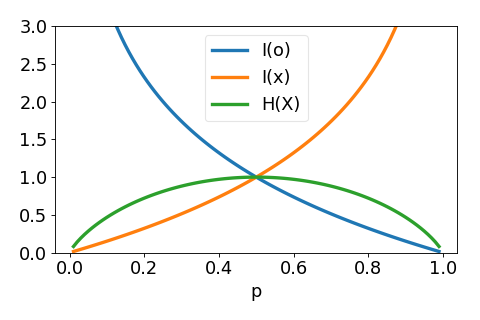

In [31]:
p = np.linspace(0.01, 0.99, num=100)
H = -p*np.log2(p) - (1-p)*np.log2(1-p)
fig, ax = plt.subplots(1, figsize=(6, 4), sharex=True)
ax.set_xlabel('p')
ax.plot(p, -np.log2(p), label='I(o)', lw=3)
ax.plot(p, -np.log2(1-p), label='I(x)', lw=3)
ax.plot(p, H, label='H(X)', lw=3)
ax.set_ylim([0, 3])
plt.legend();

**Ejercicio:**

Sea una fuente que escupe un entero x que está entre 0 y 31

Considere el resultado de las siguientes preguntas ¿Cúal tiene mayor entropía?
- ¿Es x igual a 0?
- ¿Es x un número primo?
- ¿Es x mayor a 15?

¿Cuál es el número mínimo de preguntas con respuesta si/no que se deben hacer para adivinar el valor de x?


### Ejemplo: Meteorólogos del siglo XIX

- Nos encontramos a finales del siglo XIX
- La estación meteorológica de Niebla hace una predicción del tiempo en Valdivia
- Esta información se envía a Valdivia a través de telegrafo
- Calcule la cantidad de información promedio que envía la estación a Valdivia en cada escenario usando la **entropía de Shannon**

**Escenario 1:** Dos posibilidades: Lluvia y nublado, con probabilidad $1/2$ y $1/2$, respectivamente

**Escenario 2:** Una posibilidad: Lluvia, con probabilidad $1$

**Escenario 3:** Cuatro posibilidades: Lluvia, Nublado, Nubosidad parcial, soleado, con probabilidad $1/2$, $1/4$, $1/8$ y $1/8$, respectivamente

1. Las probabilidades de cada mensaje son $2^{-1}$, $2^{-2}$, $2^{-3}$ y $2^{-3}$
1. La cantidad de información de cada mensaje es: 1, 2, 3 y 3 bits, respectivamente
1. La entropía es $1/2 + 1/2 + 3/8 + 3/8 = 1.75$ bits

Para el **escenario 3** códifique las alternativas usando un alfabeto de códigos binarios

> ¿Cómo le asignamos un código a cada alternativa?

### Código de ancho fijo

- Tenemos cuatro estados, necesitamos 2 bits
- Cada estado: 00, 01, 10, 11
- En este caso resulta equivalente a asumir equiprobabilidad 
- La entropía es 2 bits

### Código de ancho variable (prefijo)

- Se usa 1, 2, 3 y 3 bits para cada estado, según su probabilidad de aparición
- La entropía es 1.75 bits
- Podemos describir este escenario según
    - Primera decisión equiprobable: Lluvia **(0)** vs El resto (1)
    - Segunda decisión equiprobable: Nublado **(10)** vs El resto menos lluvia (11)
    - Tercera decisión equiprobable: Nubosidad parcial **(110)** vs soleado **(111)**
- Podemos escribir esto como un dendograma

<center><img src="images/dendogram.png" width="600"></center>

- Algoritmo de codificación con forma de árbol en base 2
- Los mensajes codificados están en las hojas del árbol
- **Código préfijo**: Ningún código puede ser prefijo de otro. 
- El código prefijo garantiza decodificación sin ambiguedad


**Ejercicio**

Decodifique la predicción del tiempo para los próximos tres días: 101100 

**Ejemplo de código ambiguo** 

Si el código de lluvia fuera **1** en lugar de 0, decodifique el siguiente mensaje: 11111



### Ejemplo: Entropía y cantidad de bits del fragmento del famoso texto


In [32]:
# Código de largo fijo:
print(5*len(texto))
# Código de largo variable:
freq = np.array(list(Counter(texto).values()))
p = freq/np.sum(freq)
print(int(-np.sum(p*np.log2(p))*len(texto)))

11830
9530


**Reflexionemos:** 
- ¿Es la codificación de largo variable *lossless* o *lossy*?
- En ciertos casos las palabras son más largas de lo que eran originalmente, ¿Cómo comprimimos entonces?

## Codificación de Huffman

Un algoritmo sencillo de codificación de tipo prefijo:

1. Se estima la probabilidad $p_i$ de cada símbolo
1. Se ordenan los símbolos en orden descendente según $p_i$
1. Juntar los dos con probabilidad menor en un grupo, su probabilidad se suma
1. Volver al paso 2 hasta que queden dos grupos
1. Asignarle 0 y 1 a las ramas izquierda y derecha del árbol, respectivamente
1. El código resultante se lee desde la raiz hasta la hoja

<center><a href="http://www.skylondaworks.com/sc_huff.htm"><img src="images/huff.gif" width="600"></a></center>


**Debilidad de Huffman:** 
- Códigos con diccionarios/probabilidades variables
- En ese caso combiene usar codificación aritmética o Lempel-Ziv



***
***
***

Hemos visto que en general las señales/datos tienen alta redundancia 

> Piense por ejemplo en el caso de las imágenes o el lenguaje (contexto)

Hemos visto también como comprimir datos

En particular 
1. Transformamos los datos tal de hacerlos "más independientes" y opcionalmente los cuantizamos
1. Codificamos los datos con una distribución que sea óptima para el canal de transmisión

Este último paso es lo que llamamos **codificación de fuente**

A continuación revisaremos un importante teorema enunciado por Shannon respecto a la **codificación de un mensaje**

# Teorema de codificación de fuente de Shannon (*Source coding theorem*)


>Dada una variable aleatoria $X$ con entropía $H(X)$ existe una codificación de largo variable cuyo largo de palabra promedio $\bar L$ satisface

>$$
H(X) \leq \bar L < H(X) + 1
$$

Es decir que el límite inferior teórico del largo de palabra es $H(X)$

Esta codificación sin pérdida y de largo variable la llamamos **codificación entrópica** 

Este teorema 
- nos dice cuanto podemos comprimir una señal sin que hayan pérdidas antes de enviarla por un canal (libre de ruido)
- justifica la definición de entropía como medida de la cantidad de información


Otra forma de ver el teorema

Sea una fuente $X$ que emite $N$ mensajes. 

> Los N mensajes pueden comprimirse en $N H(X)$ [bits] o más con riesgo de pérdida despreciable ($N\to\infty$)

Por el contrario

> Si comprimimos en menos de $N H(X)$ [bits] la pérdida está garantizada

#### Probando el teorema

Sea una codificación C para una variable aleatoria $X$ con N posibles símbolos

Cada símbolo $x_i$ tiene una probabilidad de ocurrencia $p_i \in [0, 1]$ con $\sum_i p_i = 1$ y un largo de código $L_i$

Luego el largo promedio de los códigos es

$$
\bar L = \sum_{i=1}^N p_i L_i
$$

¿Qué valores de $L_i$ resultan en el menor $\bar L$? 

> El largo óptimo es $L_i^* = -\log_2 p_i$ y el promedio sería $\bar L^* = H(X)$

Digamos que proponemos otro largo $\hat L_i = - \log_2 q_i$, asumiendo que $\sum_i q_i = 1$

Luego el largo promedio sería

$$
\begin{align}
\bar L &= \sum_{i=1}^N p_i \hat L_i  = - \sum_{i=1}^N p_i \log_2 q_i \nonumber \\
&= - \sum_{i=1}^N p_i \log_2 q_i - \sum_{i=1}^N p_i \log_2 p_i + \sum_{i=1}^N p_i \log_2 p_i \nonumber \\
&= - \sum_{i=1}^N p_i \log_2 p_i + \sum_{i=1}^N p_i \log_2 \frac{p_i}{q_i} \nonumber \\
&= H(X) + \sum_{i=1}^N p_i \log_2 \frac{p_i}{q_i} \geq H(X) \nonumber
\end{align}
$$
> Con esto probamos que no hay mejor largo que $-\log_2 p_i$

Notemos que los $L_i^*$ no tendrían porque ser un número enteros 

> En general la codificación óptima cumple: $H(X) \leq \bar L^* < H(X) + 1$

- Se puede estar entre esas cotas con el algoritmo de Huffman
- La codificación aritmética en cambio casi siempre llega a la cota inferior
- La codificación de Huffman y aritmética son **codificaciones entrópicas**

## Divergencia de Kullback-Leibler (KL)

**Divergencia:** Medida de similitud entre distribuciones estadísticas (No es exactamente una distancia)

Sean dos densidades $P=\{p_1, p_2, \ldots, p_N\}$ y $Q=\{q_1, q_2, \ldots, q_N\}$ sobre una misma variable $x$. Su **divergencia de KL** es

$$
\begin{align}
D_{\text{KL}} \left ( P||Q \right) &= \sum_{i=1}^N p_i \log_2 \frac{p_i}{q_i} \nonumber \\
&= -\sum_{i=1}^N p_i \log_2 q_i + \sum_{i=1}^N p_i \log_2 p_i \nonumber \\
&= H_Q(P) -H(P) \geq 0 \nonumber 
\end{align}
$$

donde 
- $H(P)$ es la entropía de $P$ 
- $H_Q(P)$ es la **entropía cruzada** de $P$ con $Q$
- La desigualdad final se conoce como [desigualdad de Gibbs](https://en.wikipedia.org/wiki/Gibbs%27_inequality)
- La igualdad se cumple sólo si $P=Q$

La divergencia de KL también se conoce como la **entropía relativa de P con respecto a Q**


> La divergencia de KL nos dice la "cantidad extra" de bits necesarios para codificar P usando un código optimizado para Q

> La divergencia de KL mide cantidad de información perdida cuando uso Q para aproximar P

# Información Mutua

La información mutua entre dos variables aleatorias $X$ e $Y$ se puede definir de varias maneras

$$
\begin{align}
\text{MI}(X, Y) &= H(X) + H(Y) - H(X, Y)  \nonumber \\
&= H(Y) - H(X|Y) = H(X) - H(Y|X)   \nonumber \\
&= D_\text{KL} \left ( P_{XY} || P_{X} P_{Y} \right) \nonumber \\
&= \sum_{i} \sum_{j} P_{XY}(X=x_i, Y=y_j) \log_2 \frac{P_{XY}(X=x_i,Y=y_j)}{P_{X}(X=x_i) P_Y(Y=y_j)}, \nonumber
\end{align}
$$

donde 
- $H(X,Y)$ es la entropía conjunta
    - Cantidad de información promedio en bits de $X$ e $Y$
- $H(X|Y)$ es la entropía de $X$ condicionada en $Y$
    - Cantidad de información promedio en bits de $X$ considerando que conocemos $Y$
    - Incerteza de $X$ dado que observamos $Y$
    - Recordemos la relación entre densidad conjunta y condicional: $p(x|y)p(y) = p(x,y)$
- Se cumple que $H(X)+H(Y) \geq H(X,Y)$ por lo tanto $\text{MI}(X,Y) \geq 0$
- Si $X$ e $Y$ son independientes entonces $H(X|Y)=H(X)$ y $H(X,Y) = H(X) + H(Y)$ y $\text{MI}(X,Y) = 0$

> La información mutua mide la información compartida por $X$ e $Y$, es decir que tan dependientes son entre sí

> La información mutua nos dice la información promedio en bits que ganamos sobre $Y$ dado que observamos $X$ (y viceverza)

> La información mutua nos dice la incerteza promedio de $Y$ que eliminamos al conocer $X$ 

# Canal con ruido

Hasta ahora hemos asumido que el canal está libre de ruido

El objetivo original de Shannon era

> "Comunicación robusta a través de un canal ruidoso"

El ruido disminuye la **capacidad** del canal

### Ejemplo: Un cisne navegando por  un canal ruidoso

Imagemos que queremos transmitir una imagen binaria $X$ por un canal con ruido

El canal le cambia el valor a un 10% de los píxeles

Llamamos $Y$ a la imagen que sale del canal

Este canal de comunicación se conoce como [canal binario simétrico](https://en.wikipedia.org/wiki/Binary_symmetric_channel)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
plt.rcParams['image.cmap'] = 'gray'

th_binary, p_noise = 0.5, 0.1
img_swan_gray = plt.imread('images/gray-swan.png')[:, :, 0]
img_swan = (img_swan_gray > th_binary).astype('uint8')
Npix = len(img_swan.ravel())
p = np.random.rand(img_swan.shape[0], img_swan.shape[1])
img_noisy_swan = img_swan.copy()
img_noisy_swan[p <= p_noise] = 1-img_noisy_swan[p <= p_noise]

ax[0].imshow(img_swan); ax[0].axis('off')
ax[1].imshow(img_noisy_swan); ax[1].axis('off');

¿Cual es la entropía de cada imagen?

In [ ]:
def entropy_binary_image(img):
    p = np.count_nonzero(img.ravel())/len(img.ravel())
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

HX = entropy_binary_image(img_swan)
HY = entropy_binary_image(img_noisy_swan)
print("Entropía imagen limpia H(X): {0:0.4f} [bits/pixel]".format(HX))
print("Entropía imagen sucia H(Y): {0:0.4f} [bits/pixel]".format(HY))

¿Cual es la entropía conjunta?

In [ ]:
Npix = len(img_swan.ravel())
p00 = np.count_nonzero((img_swan == 0) & (img_noisy_swan == 0))/Npix
p01 = np.count_nonzero((img_swan == 0) & (img_noisy_swan == 1))/Npix
p10 = np.count_nonzero((img_swan == 1) & (img_noisy_swan == 0))/Npix
p11 = np.count_nonzero((img_swan == 1) & (img_noisy_swan == 1))/Npix
print(np.array([p00, p01, p10, p11]))

HXY = -(p00*np.log2(p00) + p01*np.log2(p01) + p10*np.log2(p10) + p11*np.log2(p11))
print("Entropía conjunta H(X,Y): {0:0.6f} [bits/pixel]".format(HXY))

¿Cuáles son las entropía condicionales?

In [ ]:
print("H(X|Y): {0:0.6f} [bits/pixel]".format(HXY-HY))
print("H(Y|X): {0:0.6f} [bits/pixel]".format(HXY-HX))

¿Cual es la información mutua?

In [ ]:
MIXY = HX + HY - HXY
print("Información mutua IM(X,Y): {0:0.6f} [bits/pixel]".format(MIXY))

¿Cúal es la entropía del ruido?

In [ ]:
H_noise = -p_noise*np.log2(p_noise) - (1-p_noise)*np.log2(1-p_noise)
print("Entropía del ruido H(N): {0:0.6f} [bits/pixel]".format(H_noise))

Consideremos que $Y = X + N$

Entonces
$$
H(Y|X) = H(X+N|X) = H(N|X) = H(N)
$$

> En un canal ruidoso la entropía condicional de la salida dada la entrada es equivalente a la entropía del ruido añadido a la entrada

<img src="images/entropy_mi_diagram.png">

La eficiencia de la transmisión está dada por la proporción de entropía de $Y$ que es compartida por $X$

$$
E = \frac{\text{MI}(X,Y)}{H(Y)} \in [0, 1]
$$



In [ ]:
MIXY/HY

Un 37% de la entropía de la salida depende de la entrada

¿Qué ocurre con la información mutua y con la eficiencia de transmisión cuando el canal se vuelve más o menos ruidoso?

# Corrección de errores debidos al ruido

Queremos ser capaces de recuperar X a partir de Y

Cuando el canal tiene ruido necesitamos robustecer el código de X

Esto se logra **agregando redundancia** a nuestro código

- Enviar el mensaje varias veces: **repetition code**
- Agregar al código uno o más **bits de paridad**


### Ejemplo: *repetition code*

Si queremos enviar 0110011 lo repetimos una cierta cantidad de veces

$X$ = 000 111 111 000 000 111 111 

$N$ = 001 000 000 000 000 110 000

$Y$ = 001 111 111 000 001 001 111

Si aplicamos decodificación por mayoría: 0 1 1 0 0 **0** 1

Reducimos la probabilidad de error por un factor 3

La tasa es $R = k/n = 3$ donde $k$ son los bits de información y $n$ los bits transmitidos

### Ejemplo: paridad

Sea una tira binaria de 16 bits $s=[0,1,0,1,0,0,0,0,1,1,1,0, 0,1,1,0]$ Se ordena como una matriz de 4x4

$$
\begin{array}{|c c c c|c}
  0 & 1 & 0 & 1 & 0\\
  0 & 0 & 0 & 0 & 0\\
  1 & 1 & 1 & 0 & 1\\
  0 & 1 & 1 & 0 & 0 \\ \hline
  1 & 1 & 0 & 1 & 
\end{array}
$$

Si el número de 1's de una fila o columna es par se agrega un 0, de lo contrario se agrega un 1

Finalmente se crea una nueva tira de largo 24

$s_p=[0,1,0,1,\textbf{0}, 0,0,0,0,\textbf{0}, 1,1,1,0, \textbf{1}, 0,1,1,0, \textbf{0}, \textbf{1}, \textbf{1}, \textbf{0}, \textbf{1}]$ 

- Al recibir este código se comprueba que las paridades estén bien
- Si no lo están podriamos pedir nuevamente la tira binaria
- Aumentamos el mensaje de 16 a 24 [bits], la tasa es $R=16/24=0.666$

**Ejercicio:** Si tengo un string de NxN de largo y quiero proteger con bits de paridad ¿Cúantos bits agrego?


# Teorema de codificación de canal de Shannon (*Channel coding theorem*)

Se define la capacidad de un canal con entrada $X$ y salida $Y$ como

$$
C = \max_{P(X)} \text{MI}(X,Y) ~\text{[bits/símbolo]} 
$$

La distribución $P^*(X)$ que maximiza la capacidad del canal es la distribución de entrada óptima para ese canal

Notemos que si el canal no tiene ruido entonces $Y=X$ y la capacidad está dada por la entropía de $X$

> El ruido disminuye la capacidad de un canal

Al respecto Shannon enunció el siguiente teorema

> Sea un canal con capacidad $C$ y una fuente $X$ que transmite a una taza de $R$

>Si $R \leq C$ entonces existe un un largo de codificación para $X$ que puede transmitirse con error arbitrariamente pequeño

> Para una una probabilidad de error de bit aceptable $p_e$, se puede alcanzar una taza de transmisión
$$
R(p_e) = \frac{1}{1 + p_e \log_2(p_e) + (1-p_e) \log_2(1-p_e)}
$$

> Para un cierto $p_e$ no es posible alcanzar una taza mayor a $R(p_e)$

### Ejemplo: Canal binario simétrico

¿Cuál es la distribución de entrada que maximiza la información mutua del canal?

In [ ]:
p_flip, tol = 0.1, 1e-2
np.random.seed(0)
seed_image = np.random.rand(img_swan_gray.shape[0], img_swan_gray.shape[1])
flip_mask = np.random.rand(img_swan_gray.shape[0], img_swan_gray.shape[1]) <= p_flip

binarization_threshold = np.linspace(0.01, 0.999, num=100)
MIXY = []
for th in binarization_threshold:
    img_X = (img_swan_gray > th).astype('uint8')
    img_Y = img_X.copy()
    img_Y[flip_mask] = 1-img_Y[flip_mask] 
    p00 = np.count_nonzero((img_X == 0) & (img_Y == 0))/Npix
    p01 = np.count_nonzero((img_X == 0) & (img_Y == 1))/Npix
    p10 = np.count_nonzero((img_X == 1) & (img_Y == 0))/Npix
    p11 = np.count_nonzero((img_X == 1) & (img_Y == 1))/Npix
    HX = -(p00 + p01)*np.log2(p00 + p01+tol) -(p10 + p11)*np.log2(p10 + p11+tol)
    HY = -(p00 + p10)*np.log2(p00 + p10+tol) -(p01 + p11)*np.log2(p01 + p11+tol)
    HXY= -(p00*np.log2(p00+tol) + p01*np.log2(p01+tol) + p10*np.log2(p10+tol) + p11*np.log2(p11+tol))
    MIXY.append(HX + HY - HXY)
    
fig, ax = plt.subplots(2, 2, figsize=(9, 7), tight_layout=True)
ax[1, 0].axis('off'); ax[0, 1].axis('off'); ax[1, 1].set_xticks([0, 1]); 
ax[1,1].set_xlabel('X'); ax[1, 1].set_ylabel('P(X)');
ax[0, 0].set_ylabel('Información mutua')
ax[0, 0].set_xlabel('Umbral de binarización');
best_th = binarization_threshold[np.argmax(MIXY)]
ax[0, 1].text(0.0,0.5, "Mejor umbral: {0:0.4f}\nMejor MI(X,Y): {1:0.4f}".format(best_th, np.amax(MIXY)))
ax[0, 0].plot(binarization_threshold, MIXY); 
ax[1, 0].imshow((img_swan_gray > best_th).astype('uint8')); 
ax[1, 1].hist((img_swan_gray > best_th).astype('uint8').ravel(), 
              align='mid', range=[-0.5, 1.5],
              bins=2, density=True, histtype='bar', ec='black');

Digamos que la entrada $X$ tiene probabilidad $p$ de ser 0 y $(1-p)$ de ser 1 (imagen binaria) 

Es decir las *probabilidades a priori* son $P(X=0)=p$, $P(X=1)=(1-p)$ 

Dijimos que el canal cambia un 10\% de los pixeles de $X$

Entonces las verosimilitudes son $P(Y=1|X=1) = 0.9$, $P(Y=1|X=0) = 0.1$, $P(Y=0|X=1) = 0.1$, $P(Y=0|X=0) = 0.9$

Las probabilidades marginales de la salida son:
- $P(Y=1) = \sum_x P(Y=1|X=x)P(X=x)  = 0.9(1-p) + 0.1p = 0.9 - 0.8p $
- $P(Y=0) = \sum_x P(Y=0|X=x)P(X=x)  = 0.1(1-p) + 0.9p = 0.1 + 0.8p= 1 - P(Y=1) $ 

y su entropía es $H(Y) = - (0.9 - 0.8p) \log_2(0.9 - 0.8p) - (0.1 + 0.8p) \log_2(0.1 + 0.8p)$


La entropía condicional es 
$$
H(Y|X) = \sum_x H(Y|X=x)P(X=x) = - 0.9 \log_2(0.9) - 0.1 \log_2 (0.1)
$$
que no depende de $p$

El máximo de la información mutua:
$$
\frac{d}{dp} \text{MI}(X,Y) = \frac{d}{dp} H(Y) - \frac{d}{dp} H(Y|X) = \frac{d}{dp} H(Y) = 0 \rightarrow p^*=\frac{1}{2}
$$

Notemos que no importa que porcentaje de corrupción tenga el canal.

Finalmente la capacidad del canal es

$$
C = \text{MI}_p^* (X,Y) = 1 + 0.9 \log_2(0.9) + 0.1 \log_2 (0.1) = 0.531 \text{[bits]}
$$

> Si usamos P^* podemos transmitir sin perdidas a una taza $R=k/n=0.531$, es decir que por $k$ bits de información tenemos que transmitir aproximadamente $2k$ bits



## Teorema de Shannon-Hartley

- Sea un canal con ancho de banda B [Hz] (rango de frecuencias que un canal puede transmitir) y potencia de señal S [W] y potencia del ruido N [W] (aditivo blanco gaussiano), entonces su capacidad es

$$
C = B \log_2 \left(1 + \frac{S}{N} \right) \text{[bits/s]}
$$

- Si la velocidad de transmisión de un canal es R [bits/s] y R < C entonces la probabilidad de errores de comunicación tiende a cero.
- Las limitaciones de un sistema de comunicación son **Ancho de banda** y el ruido **Ruido**



http://home.iitk.ac.in/~adrish/Shannon/information_theory.php